In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
# import cv2 as cv
import os
import pandas as pd
import h5py
import seaborn as sns
import scipy as sc

# import statsmodels.api as sm

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K

%matplotlib inline
matplotlib.style.use('ggplot')

matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision = 3, suppress = True) # formats the output of np arrays to look nicer
print('Keras version:', keras.__version__)

Keras version: 3.6.0


In [2]:
data_root = os.path.normpath('.') # Path to the data set and the labels
hd_file_large = os.path.join(data_root, 'physio.h5') # File name of the full hdf5 file
label_file = os.path.join(data_root, 'records_filtered.csv') # File name of the labels

In [3]:
df = pd.read_csv(label_file, header=None, names=["subject_id","study_id","icd_code","icd_title","path"])

df.head()

,subject_id,study_id,icd_code,icd_title,path
0,10007058,41688028,I214,Myocardial infarction,files/p1000/p10007058/s41688028/41688028
1,10007058,47527771,I214,Myocardial infarction,files/p1000/p10007058/s47527771/47527771
2,10007058,47979034,I214,Myocardial infarction,files/p1000/p10007058/s47979034/47979034
3,10007058,40778825,I214,Myocardial infarction,files/p1000/p10007058/s40778825/40778825
4,10007058,49692275,I214,Myocardial infarction,files/p1000/p10007058/s49692275/49692275


In [4]:
df = pd.read_csv(label_file, header=None, names=["subject_id","study_id","icd_code","icd_title","path"])

# For MIMIC, let's assume we want to group by 'icd_title', which represents the condition
df_stat = df.groupby('icd_title').agg('count').reset_index()

# Adjust the column names and calculate percentages
df_stat = df_stat[['icd_title', 'subject_id']]  # Using 'subject_id' for counting
df_stat.columns = ['label', 'recordings']  # Renaming for consistency
df_stat = df_stat.assign(percent=(100 * np.around(df_stat.recordings / df.shape[0], 2)).astype(int))  # Replace np.int with int

# Print the statistics
print(df_stat)

# Get the unique set of labels (ICD titles)
df_set = list(df.icd_title.unique())

                     label  recordings  percent
0      Atrial Fibrillation        6137       38
1    Myocardial infarction        7726       48
2  Ventricular tachycardia        2298       14


['48986121', '49441741', '42095099']


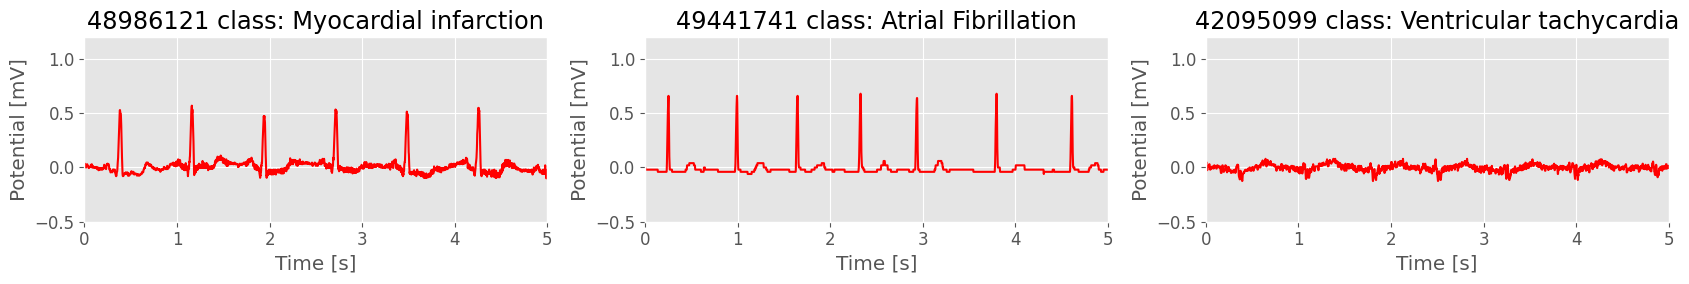

In [5]:
# from physionet_processing import fetch_h5data
def extend_ts(ts, length):
    extended = np.zeros(length)
    siglength = np.min([length, ts.shape[0]])
    extended[:siglength] = ts[:siglength]
    return extended 

def fetch_h5data(h5file, index_list, sequence_length):
    '''Out: array [samples, sequence]'''
    
    dataset_list = list(h5file.keys())
    load_list = [dataset_list[index] for index in index_list]
    
    print(load_list)
    data = []
    for dset in load_list:
        # Extract Lead I (first lead) for MIMIC data
        data.append(extend_ts(h5file[dset]['ecgdata'][0, :], sequence_length))
    return np.vstack(data)


# Set seed for reproducibility
np.random.seed(148)

# Open MIMIC hdf5 file (replace 'mimic.h5' with the correct file path if necessary)
h5file = h5py.File(hd_file_large, 'r')

# Get a list of dataset names
dataset_list = list(h5file.keys())

# Function to get a random sample from each class (based on icd_title)
def get_sample():
    # Pick one ECG randomly from each icd_title (class)
    fid_list = [np.random.choice(df[df.icd_title == icd_title].path.values, 1)[0] for icd_title in df_set]
    return fid_list

# Select a random sample of ECGs
name_list = get_sample()

# Set sequence length (e.g., 1500 time points)
slen = 5000

# Get the index list corresponding to the selected sample
idx_list = [dataset_list.index(name.split('/')[-1]) for name in name_list]  # Assuming paths are in 'path' column

# Fetch the ECG data
data = fetch_h5data(h5file, idx_list, sequence_length=slen)

# Time axis for the plot
time = np.arange(0, slen) / 500  # Assuming sampling frequency is 300 Hz

# Set up the plot
fig, ax = plt.subplots(1, len(idx_list), figsize=(17, 3))

# Plot each ECG signal with its corresponding class (icd_title)
for i, ax1 in enumerate(ax):
    ax1.plot(time, data[i], color='r')
    ax1.set(xlim=[0, 5], xticks=np.arange(0, 5.5, 1),
            ylim=[-0.5, 1.2], yticks=np.arange(-0.5, 1.2, 0.5),
            xlabel='Time [s]', ylabel='Potential [mV]')
    ax1.set_title(name_list[i].split('/')[-1] + ' class: ' + df_set[i])

# Finalize and show the plot
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

import torch
from torch.utils.data import DataLoader


from physionet_processing import spectrogram, transformed_stats
from physionet_generator import DataGenerator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
data_root = os.path.normpath("C:\\Users\\nazrulsa\\Downloads\\test\\physio.h5")  # Base path for MIMIC dataset

records_file = os.path.join('.', 'records_filtered.csv')  

records_df = pd.read_csv(records_file, header=None, names=["subject_id","study_id","icd_code","icd_title","path"])

label_set = list(sorted(records_df['icd_title'].unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
records_df = records_df.assign(encoded=encoder.transform(records_df['icd_title']))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', records_df[['subject_id', 'icd_title', 'encoded']].head())


test_split = 0.33
idx = np.arange(records_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size=test_split,
                                         shuffle=True,
                                         random_state=123)


partition = {
    'train': list(records_df.iloc[id_train]['study_id']),  
    'validation': list(records_df.iloc[id_val]['study_id'])
}

labels = dict(zip(records_df['study_id'], records_df['encoded']))

Unique labels: ['Atrial Fibrillation' 'Myocardial infarction' 'Ventricular tachycardia']
Unique codings: [0 1 2]
Dataset labels:
    subject_id              icd_title  encoded
0    10007058  Myocardial infarction        1
1    10007058  Myocardial infarction        1
2    10007058  Myocardial infarction        1
3    10007058  Myocardial infarction        1
4    10007058  Myocardial infarction        1


In [8]:
df_stat = records_df.groupby('icd_title').agg('count').reset_index()
df_stat = df_stat[['icd_title', 'study_id']]  
df_stat.columns = ['Class', 'Recordings']  
df_stat = df_stat.assign(percent=(100 * np.around(df_stat['Recordings'] / records_df.shape[0], 2)).astype(int))  
print(df_stat)

                     Class  Recordings  percent
0      Atrial Fibrillation        6137       38
1    Myocardial infarction        7726       48
2  Ventricular tachycardia        2298       14


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\nazrulsa\AppData\Local\Temp\ipykernel_1924\1455728391.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))


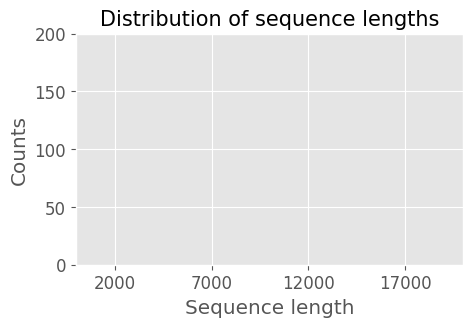

In [9]:
from physionet_processing import special_parameters

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] # universal sampling rate
sequence_length = sequence_length_max # will use the maximum sequence length

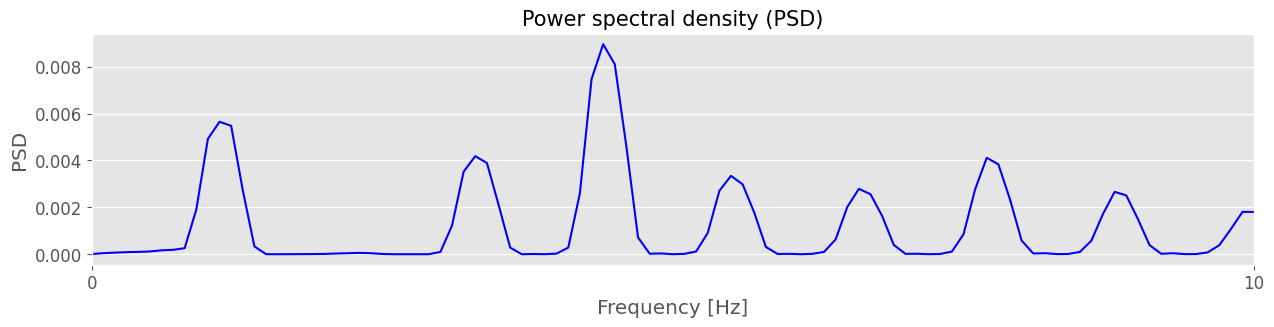

In [10]:
from scipy import signal
from physionet_processing import extend_ts

ts = h5file[dataset_list[15]]['ecgdata'][0,: ]
ts_extended = extend_ts(ts, length = sequence_length_max) # Extend it to the maximum length

f1, PSD = signal.periodogram(ts_extended, fs, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

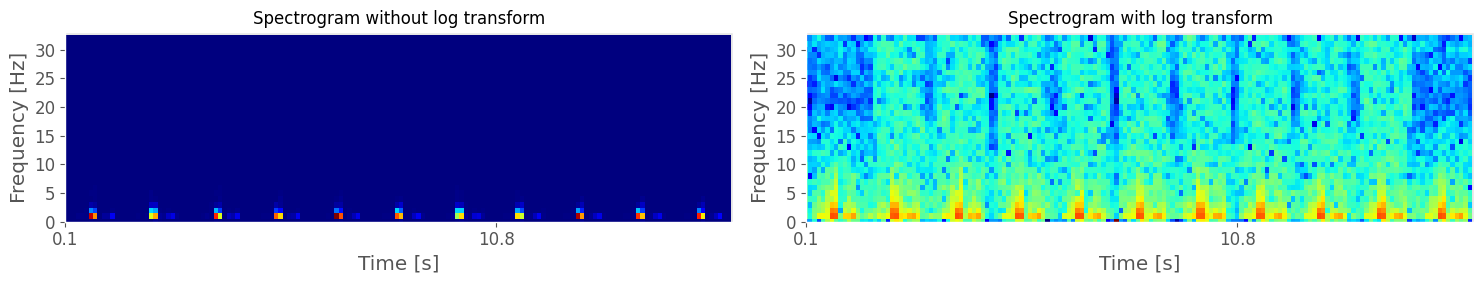

In [11]:
from physionet_processing import spectrogram

# Convert ECG into spectrograms without and with log transform
Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

# Get the frequency and time axes
f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

# Plot the spectrograms as images
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    # Replace axis labels with time from t array
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

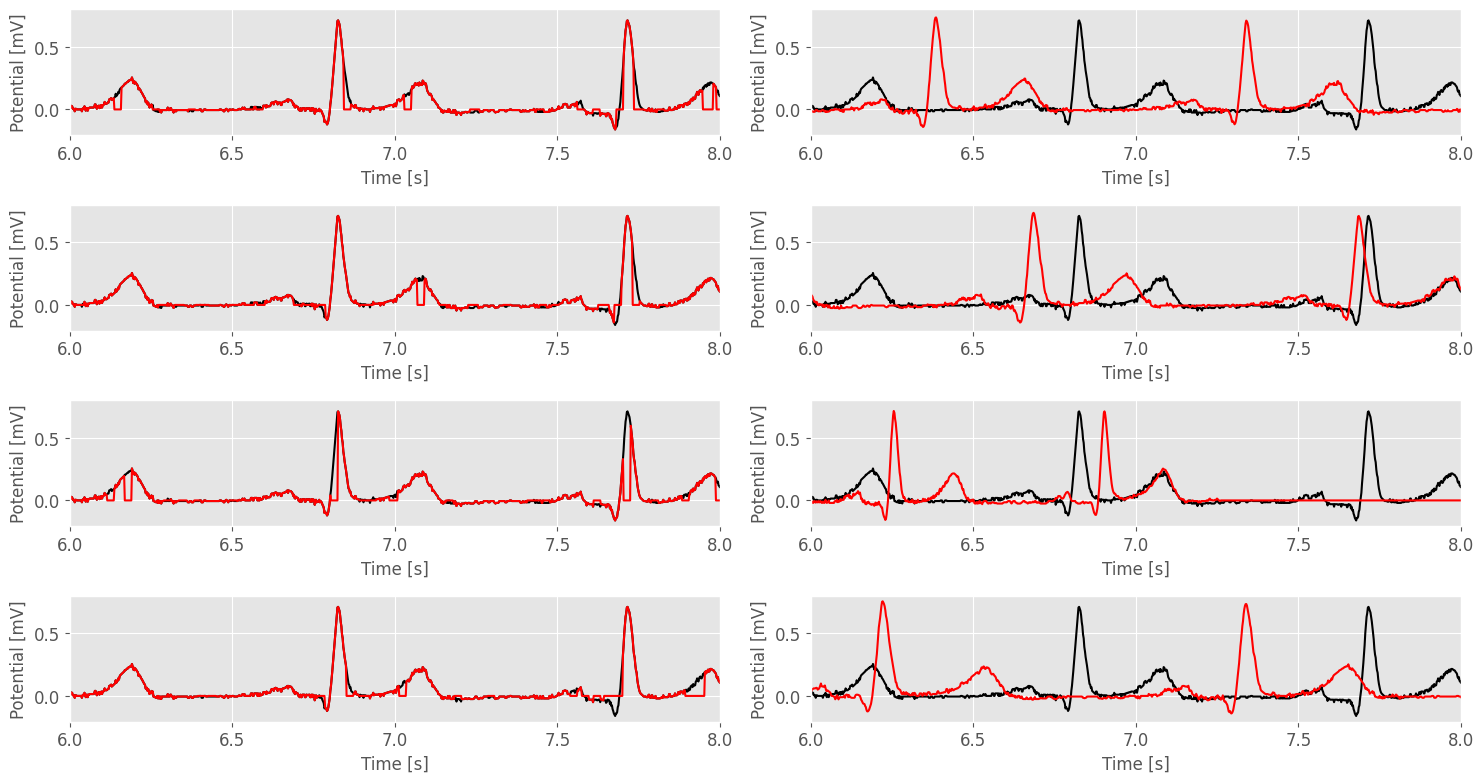

In [12]:
from physionet_processing import zero_filter, random_resample

data_zero = [] # collect the zero burst data here
data_resampled = [] # list for resampled data
runs = 4

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

# Plot the result
fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_lim = [6, 8] # zoom in on x axis
x_ticks = np.arange(x_lim[0], x_lim[1] + 0.5, 0.5) # ticks
x_label = 'Time [s]'
y_label = 'Potential [mV]'

for row in range(runs):
    
    # Plot the dropout burst data
    ax = axarr[row, 0]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_zero[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
    # Plot the resampling data
    ax = axarr[row, 1]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_resampled[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
#plt.suptitle('Data augmentation: dropout bursts and random resampling', fontsize = 15)
plt.show()
fig.savefig('physionet_augmentation.png', bbox_inches = 'tight', dpi = 150)

In [13]:
# The initialization function of the generator class defines the parameters 
# that are needed for ECG processing
'Generates data for Keras'
def __init__(self, h5file, list_IDs, labels, batch_size = 32, dim = (178, 33), 
             nperseg = 64, noverlap = 32,
             n_channels=1, sequence_length = 5000,
             n_classes = 3, shuffle = True, augment = False):
    
    'Initialization'
    self.h5file = h5file
    self.list_IDs = list_IDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.nperseg = nperseg
    self.noverlap = noverlap
    self.n_channels = n_channels
    self.sequence_length = sequence_length
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

In [14]:
def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = float)
        y = np.empty((self.batch_size), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            data = extend_ts(self.h5file[ID]['ecgdata'][:, 0], self.sequence_length)
            data = np.reshape(data, (1, len(data)))
        
            if self.augment:
            
                # dropout bursts
                data = zero_filter(data, threshold = 2, depth = 10)
            
                # random resampling
                data = random_resample(data)
            
            # Generate spectrogram
            data_spectrogram = spectrogram(data, nperseg = self.nperseg, noverlap = self.noverlap)[2]
            
            # Normalize spectrogram
            #data_transformed = norm_float(data_spectrogram, self.data_mean, self.data_std)
            data_norm = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
        
            X[i,] = np.expand_dims(data_norm, axis = 3)
        
            # Assuming that the dataset names are unique (only 1 per label)
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Load the labels:
label_df = pd.read_csv(label_file, header = None, names = ['subject_id', 'name' , 'icd_code' ,'label', 'path'])

# Hot-encode the labels
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

Unique labels: ['Atrial Fibrillation' 'Myocardial infarction' 'Ventricular tachycardia']
Unique codings: [0 1 2]
Dataset labels:
      subject_id      name icd_code                  label  \
100    10030753  44473774     I214  Myocardial infarction   
101    10030753  41968330     I214  Myocardial infarction   
102    10030753  44344265     I214  Myocardial infarction   
103    10030753  42698778     I214  Myocardial infarction   
104    10030753  45912388     I214  Myocardial infarction   
105    10030753  45850330     I214  Myocardial infarction   
106    10030753  40666933     I214  Myocardial infarction   
107    10030753  40904316     I214  Myocardial infarction   
108    10030753  47514347     I214  Myocardial infarction   
109    10030753  48968010     I214  Myocardial infarction   

                                         path  encoded  
100  files/p1003/p10030753/s44473774/44473774        1  
101  files/p1003/p10030753/s41968330/41968330        1  
102  files/p1003/p10030753/

In [16]:
from sklearn.model_selection import train_test_split

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

print(label_df.encoded)


0        1
1        1
2        1
3        1
4        1
        ..
16156    2
16157    2
16158    2
16159    2
16160    2
Name: encoded, Length: 16161, dtype: int32


In [17]:
# Parameters needed for the DataGenerator class
# Maximum sequence length
max_length = sequence_length

# Output dimensions
sequence_length = sequence_length_max # Use the maximum sequence length in the data set
spectrogram_nperseg = 64 # Spectrogram hanning window width
spectrogram_noverlap = 32 # Spectrogram hanning window overlap
n_classes = len(label_df.label.unique()) # Number of classes
print(label_df.label.unique())
batch_size = 32

# Use one spectrogram to detemine the image dimensions
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0),
                     nperseg = spectrogram_nperseg,
                     noverlap = spectrogram_noverlap,
                     log_spectrogram = True)[2]
dim = Sx_log[0].shape

['Myocardial infarction' 'Atrial Fibrillation' 'Ventricular tachycardia']


In [18]:
from physionet_generator import DataGenerator

params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(hd_file_large, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(hd_file_large, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    print(i)
    X = batch[0]
    y = batch[1]

    print('X shape:', X.shape)
    print('y shape:', y.shape)
    print('X type:', np.dtype(X[0,0,0,0]))

    if i == 1:
        break



0
X shape: (32, 155, 33, 1)
y shape: (32, 3)
X type: float64
1
X shape: (32, 155, 33, 1)
y shape: (32, 3)
X type: float64


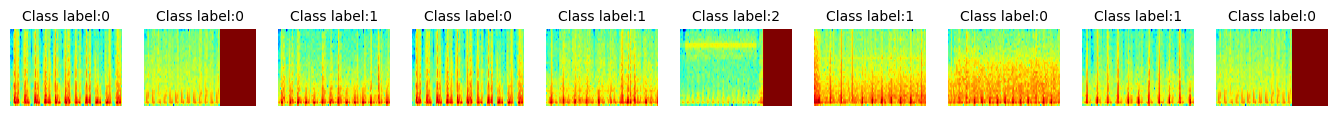

In [19]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (17, 1))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        # print(X[idx, :, :, 0])
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize = 10)
    
    plt.show()
        
    return fig

batch_idx = np.random.randint(0, batch_size, size = 10) 
fig = imshow_batch(X, y, batch_idx)
# fig.savefig('physionet_Batch.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [20]:
# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

In [21]:
# Input shape
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer

# Hyperparameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks

In [22]:
model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth

c:\Users\nazrulsa\Downloads\test\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.Masking(mask_value = 0.0))
# model.add(MeanOverTime())

# And a fully connected layer for the output
model.add(layers.Flatten())

model.add(layers.Dense(3, activation='sigmoid'))
model.summary()

c:\Users\nazrulsa\Downloads\test\.venv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 155, 33, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 155, 33, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 155, 33, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 155, 33, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 155, 33, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 78, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 78, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 78, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 78, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,555,651 (13.56 MB)

 Trainable params: 3,549,891 (13.54 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [24]:
def smoothcols(df, cols):
    
    lfrac = 0.02
    lowess = sm.nonparametric.lowess
    df_sm = df.copy()
    x = df.epoch.values

    # Replace columns with smoothed values
    for c in cols:
        df_sm[c]  = lowess(df[c].values, x, frac = lfrac)[:,1]
        
    return df_sm

In [25]:

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

: 

In [1]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=val_generator,
    validation_steps=50
)

NameError: name 'model' is not defined